In [2]:
#pip install tf-nightly

In [3]:
#pip install keras --upgrade

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB5
from tensorflow.keras.optimizers import Adam

print(tf.__version__)

2.5.0-dev20200628


In [5]:
name = "20200628-Image-EfficientNetB5-Reference"

#### Load, resize, rescale and check image data

In [6]:
# Pre-processed data files
X_train_load = pd.read_csv('./cleaned_csvs/train_pp.csv')
X_test_load = pd.read_csv('./cleaned_csvs/test_pp.csv')

# Create copies of tabular data for image pre-processing
X_train_pp = X_train_load.copy()
X_test_pp = X_test_load.copy()

# Separate target from predictors
y_train = X_train_pp.target
X_train_pp.drop(['target'], axis=1, inplace=True)
targets = np.array(y_train, dtype="uint8")

# Create lists of the image names for parsing on import
X_train_img = X_train_load['image_name']
X_test_img = X_test_load['image_name']

#Create path to images for import
img_folder_train = './siim-isic-melanoma-classification/jpeg/train/'
img_folder_test = './siim-isic-melanoma-classification/jpeg/test/'

# Define required image size and batch size for feeding to model
image_size = 224
batch_size = 64
test_batch_size = 2

In [7]:
print(f'Number of Training Examples = {X_train_pp.shape[0]}')
print(f'Number of Test Examples = {X_test_pp.shape[0]}\n')

print("y_train.shape:", y_train.shape)

Number of Training Examples = 33126
Number of Test Examples = 10982

y_train.shape: (33126,)


In [8]:
# Skip the next two steps if loading pre-resized npy file
X_train_np = np.load(f'./npy_files/X_train_jpg_{image_size}.npy')

In [9]:
# Import and resize (remember cv2 imports as BGR, not RGB)
# X_train = []
# for image_get in tqdm(X_train_img):
#     img_train = cv2.imread(img_folder_train + '{}.jpg'.format(image_get))
#     img_train = cv2.resize(img_train,(image_size,image_size))
#     img_train = cv2.cvtColor(img_train, cv2.COLOR_BGR2RGB)
#     X_train.append(img_train)

In [10]:
# # convert to numpy array
# X_train_np = np.array(X_train)
# # save to npy file
# np.save(f'./npy_files/X_train_jpg_{image_size}.npy', X_train_np)

Size of X_train_np is:  (33126, 224, 224, 3)


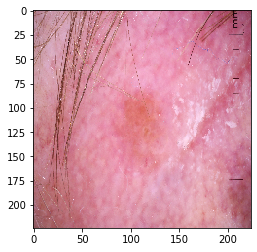

In [11]:
print("Size of X_train_np is: ", X_train_np.shape)
plt.imshow(X_train_np[0])
plt.show()

In [12]:
# Skip the next two steps if loading pre-resized npy file
X_test_np = np.load(f'./npy_files/X_test_jpg_{image_size}.npy')   

In [13]:
# # Import and resize (remember cv2 imports as BGR, not RGB)
# X_test = []
# for image_get in tqdm(X_test_img):
#     img_test = cv2.imread(img_folder_test + '{}.jpg'.format(image_get))
#     img_test = cv2.resize(img_test,(image_size,image_size))
#     img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
#     X_test.append(img_test)

In [14]:
# # convert to numpy array
# X_test_np = np.array(X_test)
# # save to npy file
# np.save(f'./npy_files/X_test_jpg_{image_size}.npy', X_test_np)

Size of X_test_np is:  (10982, 224, 224, 3)


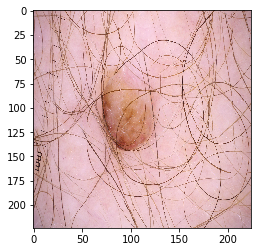

In [15]:
print("Size of X_test_np is: ", X_test_np.shape)
plt.imshow((X_test_np[0]))
plt.show()

#### Create image data generator for Tensorflow model

In [16]:
# Allow for limited image data for testing model first
lim = 33126
X_train_np_lim = X_train_np[:lim]
targets_lim = targets[:lim]

In [17]:
#Prepare training validation Set (Using 20% held back for validation)
holdback_pct = 0.20
num_val_samples = int(len(X_train_np_lim) * holdback_pct)
train_features = X_train_np_lim[:-num_val_samples]
train_targets = targets_lim[:-num_val_samples]
val_features = X_train_np_lim[-num_val_samples:]
val_targets = targets_lim[-num_val_samples:]

print("Number for training samples: ", len(train_features))
print("Number for validation samples: ", len(val_features))

Number for training samples:  26501
Number for validation samples:  6625


In [18]:
# Allow for image manipulation - care not to make transformations on training set and not test set
train_datagen = ImageDataGenerator(rescale=1./image_size-1)
train_generator = train_datagen.flow(train_features,train_targets,batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./image_size-1)
validation_generator = validation_datagen.flow(val_features,val_targets,batch_size=batch_size)

full_datagen = ImageDataGenerator(rescale=1./image_size-1)
full_generator = full_datagen.flow(X_train_np,targets,batch_size=batch_size)

# Choose batch to ensure no samples are missed
test_datagen = ImageDataGenerator(rescale=1./image_size-1)
test_generator = test_datagen.flow(X_test_np,batch_size=test_batch_size, shuffle=False)

In [19]:
# Analyze class imbalance in the targets
counts = np.bincount(train_targets[:])
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_targets)
    )
)
counts_val = np.bincount(val_targets[:])
print(
    "Number of positive samples in validation data: {} ({:.2f}% of total)".format(
        counts_val[1], 100 * float(counts_val[1]) / len(val_targets)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]
class_weight = {0: weight_for_0, 1: weight_for_1}

Number of positive samples in training data: 470 (1.77% of total)
Number of positive samples in validation data: 114 (1.72% of total)


#### Build the model

In [ ]:
# First, instantiate a base model with pre-trained weights.
base_model = keras.applications.EfficientNetB5(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(image_size, image_size, 3),
    include_top=False)  # Do not include the ImageNet classifier. Top off the model with Sigmoid instead.

In [ ]:
# Then, freeze the base model for the first round of training.
base_model.trainable = False #Don't update the imagenet parameters (yet), we want to benefit from those.

In [ ]:
inputs = keras.Input(shape=(image_size, image_size, 3))

relu_initializer = keras.initializers.he_uniform(seed=1)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning.
x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# A Dense header with a single unit (binary classification)
# x = keras.layers.Dense(128, activation='relu', kernel_initializer=relu_initializer)(x)
# x = layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(1, activation='sigmoid')(x)

cnn_model = keras.Model(inputs, outputs)
cnn_model.summary()

In [ ]:
# Create a schedule for learning rate decay
initial_learning_rate = 0.001 # 0.001 is Adam default
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=830,# On the basis of 415 steps per epoch, so decays every two epochs
    decay_rate=0.80, # Try different values to get the best val_auc score after x epochs
    staircase=True)

In [ ]:
cnn_filepath = f'./trained_weights/cnn/{name}'
callbacks = [ModelCheckpoint(cnn_filepath+"_at_epoch_{epoch}.h5")]
#              ModelCheckpoint(
#                             filepath=cnn_filepath+"_at_best_epoch.h5",
#                             save_best_only=True,  # Only save a model if `val_auc` has improved.
#                             monitor='val_auc',
#                             mode='max',
#                             verbose=1,
#                             )]

metrics = [keras.metrics.AUC(name="auc"), 'binary_crossentropy']

#cnn_model.compile(optimizer=Adam(learning_rate=lr_schedule),
cnn_model.compile(optimizer=Adam(learning_rate=0.002),
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics=metrics)

history_cnn = cnn_model.fit(
                            #train_generator, #Use for train/test split
                            full_generator, # Use for all data
                            steps_per_epoch=len(X_train_np) / batch_size, # training data - all/vs split
                            epochs=20,
                            verbose=1,
                            # validation_data=validation_generator,
                            callbacks=callbacks,
                            # class_weight=class_weight
                           )

In [ ]:
# Save the model
cnn_model.save(f'./saved_models/{name}.h5')

In [ ]:
# Determine AUC score
# Pick out the history data that we want
auc = history_cnn.history['auc']
#val_auc = history_cnn.history['val_auc']
loss = history_cnn.history['loss']
#val_loss = history_cnn.history['val_loss']
epochs = range(len(auc))

train_auc = auc[-1]
print("Train AUC: ",train_auc)

#test_auc = val_auc[-1]
#print("Test AUC: ",test_auc)

In [ ]:
# Plot training & validation accuracy values
plt.plot(epochs, auc, 'r')
#plt.plot(epochs, val_auc, 'b')
plt.title('Model accuracy')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
# Recreate the same model from file if required
cnn_model = keras.models.load_model(f'./saved_models/{name}.h5')

In [21]:
# Load weights if required
cnn_filepath = f'./trained_weights/cnn/{name}'
# cnn_model.load_weights(cnn_filepath+"_at_best_epoch.h5")
# cnn_model.load_weights(cnn_filepath+"_at_epoch_20.h5")

#### Fine Tuning

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
cnn_model.summary()

cnn_model.compile(optimizer=Adam(1e-7),  # V low learning rate otherwise will hugely overfit
                  loss="binary_crossentropy",
                  metrics=metrics)

cnn_filepath = './trained_weights/cnn/'
callbacks = [ModelCheckpoint(cnn_filepath+"_fine_tuned_model_at_epoch_{epoch}.h5")]
#              ModelCheckpoint(
#                             filepath=cnn_filepath+"_fine_tuned_at_best_epoch.h5",
#                             save_best_only=True,  # Only save a model if `val_auc` has improved.
#                             monitor="val_auc",
#                             mode='max',
#                             verbose=1,
#                             )]

history_cnn = cnn_model.fit(#train_generator,
                          full_generator, # Use for all data
                          steps_per_epoch=len(X_train_np) / batch_size,
                          epochs=10,
                          verbose=1,
                          # validation_data=validation_generator,
                          callbacks=callbacks,
                          # class_weight=class_weight
                         )

In [ ]:
# Save the model
cnn_model.save(f'./saved_models/{name}-FineTuned.h5')

In [ ]:
# Determine AUC score
# Pick out the history data that we want
auc = history_cnn.history['auc']
# val_auc = history_cnn.history['val_auc']
loss = history_cnn.history['loss']
# val_loss = history_cnn.history['val_loss']
epochs = range(len(auc))

train_auc = auc[-1]
print("Train AUC: ",train_auc)

# test_auc = val_auc[-1]
# print("Test AUC: ",test_auc)

In [ ]:
# Plot training & validation accuracy values
plt.plot(epochs, auc, 'r')
#plt.plot(epochs, val_auc, 'b')
plt.title('Model accuracy')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Generate the predictions

In [ ]:
# Recreate the same model from file if required
# cnn_model = keras.models.load_model('./saved_models/{name}-FineTuned.h5')

In [21]:
# Load best weights if required
cnn_filepath = f'./trained_weights/cnn/{name}'

# Fine tuned:
# cnn_model.load_weights(cnn_filepath+"_fine_tuned_at_best_epoch.h5")
# cnn_model.load_weights(cnn_filepath+"_fine_tuned_model_at_epoch_2.h5")

# Tuned:
# cnn_model.load_weights(cnn_filepath+"_at_best_epoch.h5")
cnn_model.load_weights(cnn_filepath+"_at_epoch_4.h5")

In [22]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

test_generator.reset()

preds_test=cnn_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)

5491/5491 [==============================] - 918s 167ms/step


In [23]:
preds_test.shape

(10982, 1)

In [24]:
preds_test[0:10]

array([[0.00290948],
       [0.01026812],
       [0.00229397],
       [0.00100556],
       [0.07371134],
       [0.00952974],
       [0.01588878],
       [0.06839541],
       [0.05452493],
       [0.0286507 ]], dtype=float32)

#### Create predictions file and submit

In [25]:
# Use .ravel() to flatten from 10982,1 to 10982,
output = pd.DataFrame({'image_name': X_test_load.image_name,
                       'target': preds_test.ravel()})
output.to_csv(f'./predictions/{name}-Prediction.csv', index=False)

In [26]:
output.head()

,image_name,target
0,ISIC_0052060,0.002909
1,ISIC_0052349,0.010268
2,ISIC_0058510,0.002294
3,ISIC_0073313,0.001006
4,ISIC_0073502,0.073711
